# **DATA GENERATION**

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2 as cv
from glob import glob
from tqdm import tqdm
from albumentations import HorizontalFlip, VerticalFlip
train_df = pd.read_csv('/kaggle/input/aptos2019-blindness-detection/train.csv')

X = train_df['id_code']
y = train_df['diagnosis']

print("Done")

Done


## Data Augmentation
## Image Augmentation

In [2]:
import cv2
import numpy as np
import os

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
def preprocessimage(image_path, save_path):
    target_size = (256,256)
    my_image = cv2.imread(image_path)
    img = os.path.split(image_path)[-1]
    img_1 = img.split('.')[0]+"_1."+img.split('.')[1]
    
    my_image = cv2.resize(my_image, target_size)
    my_image = cv2.cvtColor(my_image, cv2.COLOR_BGR2GRAY)
    
    my_image_1 =cv2.flip(my_image,1) 
    create_dir(save_path)
    new_image_path = os.path.join(save_path, img)    
    cv2.imwrite(new_image_path, my_image)
    new_image_path = os.path.join(save_path, img_1)
    cv2.imwrite(new_image_path, my_image_1)

print("over")

over


In [3]:
from tqdm import tqdm
import numpy as np

for x in tqdm(X, desc='Processing Training Images', unit='image'):
    preprocessimage(f'/kaggle/input/aptos2019-blindness-detection/train_images/{x}.png', '/kaggle/working/Preprocessed/Data')
    

Processing Training Images: 100%|██████████| 3662/3662 [06:36<00:00,  9.24image/s]


## Label Augmentation

In [4]:
df = X.copy()
for x in df:
    x =x+"_1"
X = pd.concat([X, df], ignore_index=True)
y = pd.concat([y,y], ignore_index=True)

## Train-Test Split

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
Train_df = pd.concat([X_train,y_train] , axis=1)
Test_df = pd.concat([X_val,y_val] , axis=1)

In [8]:
Train_df['id_code'] = Train_df['id_code'].astype(str) + '.png'
Test_df['id_code'] = Test_df['id_code'].astype(str) + '.png'

# DATASET CREATION

In [15]:
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Train_df['diagnosis'] = Train_df['diagnosis'].astype(str)  # Ensure values are strings
Test_df['diagnosis'] = Test_df['diagnosis'].astype(str)


datagen=ImageDataGenerator(
    rescale=1./255,
)

batch_size = 4
image_size = 256



train_gen=datagen.flow_from_dataframe(
    dataframe=Train_df,
    directory="/kaggle/working/Preprocessed/Data",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical",
    target_size=(image_size,image_size),
    color_mode ="grayscale" 
    
)

train_dataset = tf.data.Dataset.from_generator(
    lambda: train_gen,
    output_types=(tf.float32, tf.float32), 
    output_shapes=([None,image_size, image_size, 1], [None,5]) 
)

# Repeat the dataset indefinitely
total_steps_per_epoch =len(train_gen)//batch_size
train_dataset = train_dataset.repeat(total_steps_per_epoch).prefetch(buffer_size=tf.data.AUTOTUNE)

test_gen=datagen.flow_from_dataframe(
    dataframe=Test_df,
    directory="/kaggle/working/Preprocessed/Data",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
    target_size=(image_size,image_size),
    color_mode ="grayscale")

test_dataset = tf.data.Dataset.from_generator(
    lambda: test_gen,
    output_types=(tf.float32, tf.float32), 
    output_shapes=([None,image_size, image_size, 1], [None,5]) 
)
test_dataset = test_dataset.repeat(total_steps_per_epoch).prefetch(buffer_size=tf.data.AUTOTUNE)

Found 5126 validated image filenames belonging to 5 classes.
Found 2198 validated image filenames belonging to 5 classes.


# MODEL

In [1]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Flatten, Dense, Activation, MaxPool2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization

def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(x, filters):
    x = conv_block(x, filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(x, skip_features, filters):
    x = Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(x)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)  # Downsampling part

    # Bottleneck
    b1 = Conv2D(1024, 3, activation='relu', padding='same')(p3)
    b1 = Conv2D(1024, 3, activation='relu', padding='same')(b1)

    # Decoder
    d1 = decoder_block(b1, s3, 256)
    d2 = decoder_block(d1, s2, 128)
    d3 = decoder_block(d2, s1, 64)  # Upsampling part

    # Output of U-Net
    conv_out = Conv2D(1, 1, padding="same", activation="relu")(d3)
    
    s1, p1 = encoder_block(conv_out, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)  # Downsampling part

    # Bottleneck
    b1 = Conv2D(1024, 3, activation='relu', padding='same')(p3)
    b1 = Conv2D(1024, 3, activation='relu', padding='same')(b1)

    # Decoder
    d1 = decoder_block(b1, s3, 256)
    d2 = decoder_block(d1, s2, 128)
    d3 = decoder_block(d2, s1, 64)  # Upsampling part

    # Output of U-Net
    conv_out = Conv2D(1, 1, padding="same", activation="relu")(d3)
    
    # Flatten and Dense layers
    x = Flatten()(conv_out)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(5, activation='softmax')(x)  # Assuming classification task

    # Define model
    model = Model(inputs, x, name="UNET_with_Dense")
    return model
model=build_unet((256,256,1))
model.summary()

Model: "UNET_with_Dense"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         640       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['batch_normaliz

                                                                                                  
 activation_7 (Activation)   (None, 64, 64, 256)          0         ['batch_normalization_7[0][0]'
                                                                    ]                             
                                                                                                  
 conv2d_transpose_1 (Conv2D  (None, 128, 128, 128)        131200    ['activation_7[0][0]']        
 Transpose)                                                                                       
                                                                                                  
 concatenate_1 (Concatenate  (None, 128, 128, 256)        0         ['conv2d_transpose_1[0][0]',  
 )                                                                   'activation_3[0][0]']        
                                                                                                  
 conv2d_10

                                                                    ']                            
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 64, 64, 128)          0         ['activation_15[0][0]']       
 g2D)                                                                                             
                                                                                                  
 conv2d_19 (Conv2D)          (None, 64, 64, 256)          295168    ['max_pooling2d_4[0][0]']     
                                                                                                  
 batch_normalization_16 (Ba  (None, 64, 64, 256)          1024      ['conv2d_19[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activatio

 activation_22 (Activation)  (None, 256, 256, 64)         0         ['batch_normalization_22[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_28 (Conv2D)          (None, 256, 256, 64)         36928     ['activation_22[0][0]']       
                                                                                                  
 batch_normalization_23 (Ba  (None, 256, 256, 64)         256       ['conv2d_28[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_23 (Activation)  (None, 256, 256, 64)         0         ['batch_normalization_23[0][0]
                                                                    ']                            
          

## GPU configuration

In [16]:
strategy = tf.distribute.MirroredStrategy()
print('DEVICES AVAILABLE: {}'.format(strategy.num_replicas_in_sync))

DEVICES AVAILABLE: 2


## Model Definition

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC

with strategy.scope():
    optimizer = Adam(learning_rate=0.0001, amsgrad=True, epsilon=1e-6)
    model = build_unet((256, 256, 1))
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer
        metrics=[
            'accuracy',
            Precision(),
            Recall(),
            AUC(name='auc')
        ]
    )


In [18]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_accuracy', patience=20, mode='max')
mc = ModelCheckpoint('model.keras', monitor='val_loss',mode='min' ,save_best_only=True )

# MODEL TRAINING

In [19]:
steps_per_epoch = len(Train_df) // batch_size
history = model.fit(train_dataset,
          steps_per_epoch=steps_per_epoch,
          validation_data=test_dataset,
          validation_steps=len(y_train) //batch_size,
          epochs=15,
          callbacks = [es, mc],
          verbose=1)

Epoch 1/15
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 733s 504ms/step - accuracy: 0.6804 - auc: 0.8884 - loss: 0.9601 - precision_1: 0.8116 - recall_1: 0.5147 - val_accuracy: 0.7379 - val_auc: 0.9310 - val_loss: 0.7517 - val_precision_1: 0.8757 - val_recall_1: 0.5723
Epoch 2/15
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 645s 501ms/step - accuracy: 0.7598 - auc: 0.9371 - loss: 0.7108 - precision_1: 0.8500 - recall_1: 0.6519 - val_accuracy: 0.7855 - val_auc: 0.9516 - val_loss: 0.6217 - val_precision_1: 0.8626 - val_recall_1: 0.7211
Epoch 3/15
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 642s 501ms/step - accuracy: 0.8489 - auc: 0.9712 - loss: 0.4589 - precision_1: 0.8903 - recall_1: 0.8005 - val_accuracy: 0.8613 - val_auc: 0.9704 - val_loss: 0.4788 - val_precision_1: 0.9155 - val_recall_1: 0.7867
Epoch 4/15
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 644s 503ms/step - accuracy: 0.9215 - auc: 0.9855 - loss: 0.2915 - precision_1: 0.9404 - recall_1: 0.8952 - val_accuracy: 0.8808 - val_auc: 0.9771 - val_loss: 0.4018 - val_precision_1: 0.9145

In [20]:
steps_per_epoch = len(Train_df) // batch_size
history1 = model.fit(train_dataset,
          steps_per_epoch=steps_per_epoch,
          validation_data=test_dataset,
          validation_steps=len(y_train) //batch_size,
          epochs=15,
          callbacks = [es, mc],
          verbose=1)

Epoch 1/15
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 639s 499ms/step - accuracy: 0.9905 - auc: 0.9996 - loss: 0.0267 - precision_1: 0.9910 - recall_1: 0.9903 - val_accuracy: 0.9304 - val_auc: 0.9857 - val_loss: 0.3029 - val_precision_1: 0.9386 - val_recall_1: 0.9261
Epoch 2/15
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 638s 498ms/step - accuracy: 0.9862 - auc: 0.9999 - loss: 0.0295 - precision_1: 0.9867 - recall_1: 0.9862 - val_accuracy: 0.9305 - val_auc: 0.9854 - val_loss: 0.2923 - val_precision_1: 0.9423 - val_recall_1: 0.9250
Epoch 3/15
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 641s 500ms/step - accuracy: 0.9873 - auc: 0.9998 - loss: 0.0288 - precision_1: 0.9881 - recall_1: 0.9873 - val_accuracy: 0.9277 - val_auc: 0.9857 - val_loss: 0.3038 - val_precision_1: 0.9350 - val_recall_1: 0.9215
Epoch 4/15
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 639s 499ms/step - accuracy: 0.9909 - auc: 1.0000 - loss: 0.0184 - precision_1: 0.9912 - recall_1: 0.9902 - val_accuracy: 0.9273 - val_auc: 0.9857 - val_loss: 0.3024 - val_precision_1: 0.9411

In [23]:
steps_per_epoch = len(Train_df) // batch_size
history1 = model.fit(train_dataset,
          steps_per_epoch=steps_per_epoch,
          validation_data=test_dataset,
          validation_steps=len(y_train) //batch_size,
          epochs=15,
          callbacks = [es, mc],
          verbose=1)

Epoch 1/15
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 639s 499ms/step - accuracy: 0.9925 - auc: 1.0000 - loss: 0.0156 - precision_1: 0.9928 - recall_1: 0.9921 - val_accuracy: 0.9301 - val_auc: 0.9883 - val_loss: 0.2846 - val_precision_1: 0.9414 - val_recall_1: 0.9293
Epoch 2/15
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 638s 498ms/step - accuracy: 0.9887 - auc: 0.9999 - loss: 0.0198 - precision_1: 0.9891 - recall_1: 0.9885 - val_accuracy: 0.9258 - val_auc: 0.9870 - val_loss: 0.2770 - val_precision_1: 0.9342 - val_recall_1: 0.9203
Epoch 3/15
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 638s 498ms/step - accuracy: 0.9892 - auc: 0.9999 - loss: 0.0204 - precision_1: 0.9892 - recall_1: 0.9891 - val_accuracy: 0.9242 - val_auc: 0.9829 - val_loss: 0.3369 - val_precision_1: 0.9308 - val_recall_1: 0.9195
Epoch 4/15
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 640s 500ms/step - accuracy: 0.9898 - auc: 0.9999 - loss: 0.0209 - precision_1: 0.9898 - recall_1: 0.9888 - val_accuracy: 0.9312 - val_auc: 0.9850 - val_loss: 0.2995 - val_precision_1: 0.9334

In [26]:
steps_per_epoch = len(Train_df) // batch_size
history1 = model.fit(train_dataset,
          steps_per_epoch=steps_per_epoch,
          validation_data=test_dataset,
          validation_steps=len(y_train) //batch_size,
          epochs=15,
          callbacks = [es, mc],
          verbose=1)

Epoch 1/15
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 640s 499ms/step - accuracy: 0.9895 - auc: 0.9999 - loss: 0.0199 - precision_1: 0.9898 - recall_1: 0.9893 - val_accuracy: 0.9312 - val_auc: 0.9863 - val_loss: 0.3020 - val_precision_1: 0.9354 - val_recall_1: 0.9277
Epoch 2/15
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 639s 499ms/step - accuracy: 0.9869 - auc: 0.9999 - loss: 0.0199 - precision_1: 0.9871 - recall_1: 0.9868 - val_accuracy: 0.9320 - val_auc: 0.9871 - val_loss: 0.2852 - val_precision_1: 0.9371 - val_recall_1: 0.9246
Epoch 3/15
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 639s 499ms/step - accuracy: 0.9903 - auc: 0.9999 - loss: 0.0178 - precision_1: 0.9914 - recall_1: 0.9899 - val_accuracy: 0.9230 - val_auc: 0.9853 - val_loss: 0.3125 - val_precision_1: 0.9281 - val_recall_1: 0.9172
Epoch 4/15
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 639s 499ms/step - accuracy: 0.9906 - auc: 0.9999 - loss: 0.0155 - precision_1: 0.9908 - recall_1: 0.9904 - val_accuracy: 0.9308 - val_auc: 0.9850 - val_loss: 0.3087 - val_precision_1: 0.9355

# METRICS

In [27]:
import pandas as pd
history1_data = history1.history

df1 = pd.DataFrame(history1_data)

combined_df = pd.concat([combined_df, df1], ignore_index=True)
combined_df

,accuracy,auc,loss,precision_1,recall_1,val_accuracy,val_auc,val_loss,val_precision_1,val_recall_1
0,0.706870,0.905921,0.878400,0.831441,0.542935,0.737891,0.931037,0.751658,0.875672,0.572266
1,0.773526,0.939133,0.695466,0.855869,0.674736,0.785547,0.951631,0.621736,0.862617,0.721094
2,0.870754,0.975607,0.415850,0.908739,0.824287,0.861328,0.970411,0.478787,0.915455,0.786719
3,0.937915,0.989548,0.241872,0.952207,0.918001,0.880813,0.977140,0.401768,0.914512,0.856975
4,0.964077,0.993731,0.152471,0.971101,0.957829,0.908984,0.979924,0.342330,0.930195,0.895312
5,0.982429,0.997108,0.077759,0.985473,0.980086,0.915234,0.979361,0.398941,0.923783,0.904297
6,0.983210,0.998269,0.068140,0.985507,0.982429,0.914420,0.984614,0.305682,0.937603,0.892536
7,0.987505,0.999239,0.044746,0.989045,0.987114,0.920313,0.983598,0.330918,0.930159,0.915625
8,0.986724,0.999202,0.046581,0.987480,0.985552,0.928125,0.984101,0.321422,0.936951,0.917188
9,0.989457,0.999374,0.037063,0.989449,0.988676,0.929269,0.981802,0.334077,0.939936,0.923408


## Accuracy

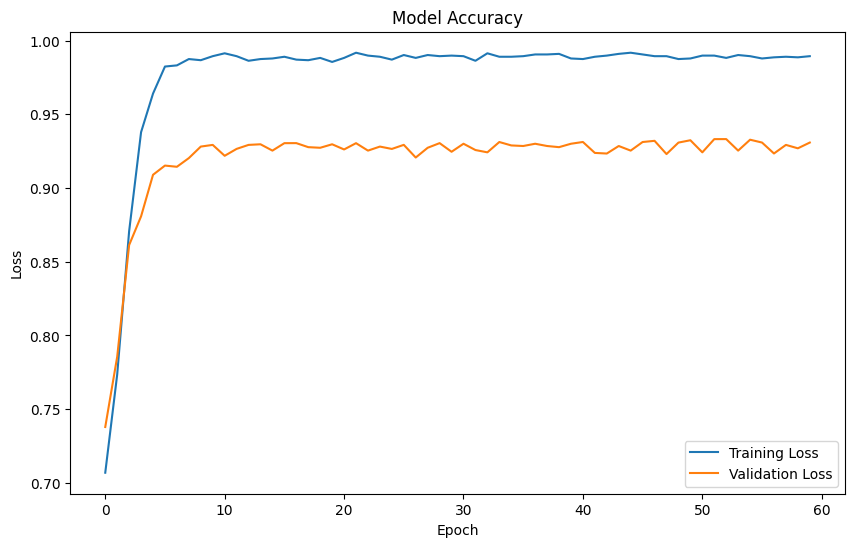

In [28]:
import matplotlib.pyplot as plt

loss_column = 'accuracy'
val_loss_column = 'val_accuracy'

plt.figure(figsize=(10, 6))

plt.plot(combined_df[loss_column], label='Training Loss')

if val_loss_column in combined_df.columns:
    plt.plot(combined_df[val_loss_column], label='Validation Loss')

plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Loss

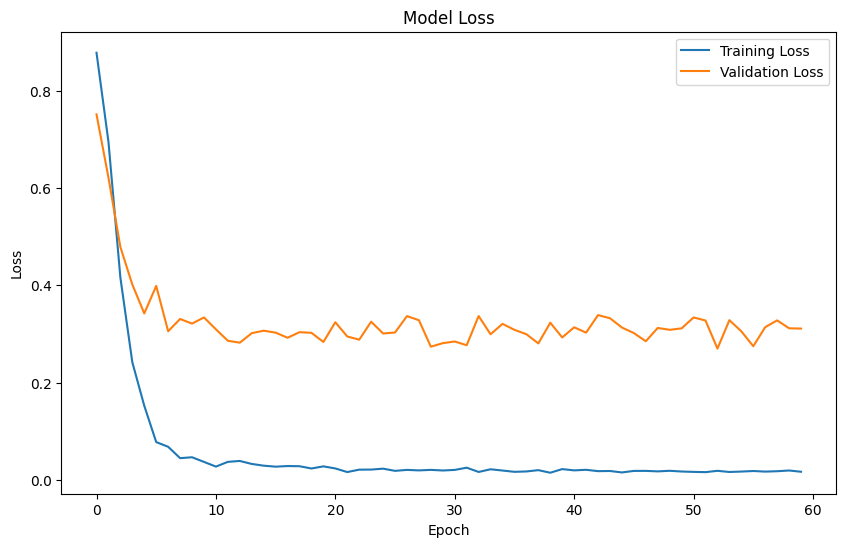

In [29]:
import matplotlib.pyplot as plt

loss_column = 'loss'
val_loss_column = 'val_loss'

plt.figure(figsize=(10, 6))

plt.plot(combined_df[loss_column], label='Training Loss')

if val_loss_column in combined_df.columns:
    plt.plot(combined_df[val_loss_column], label='Validation Loss')

plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Precision

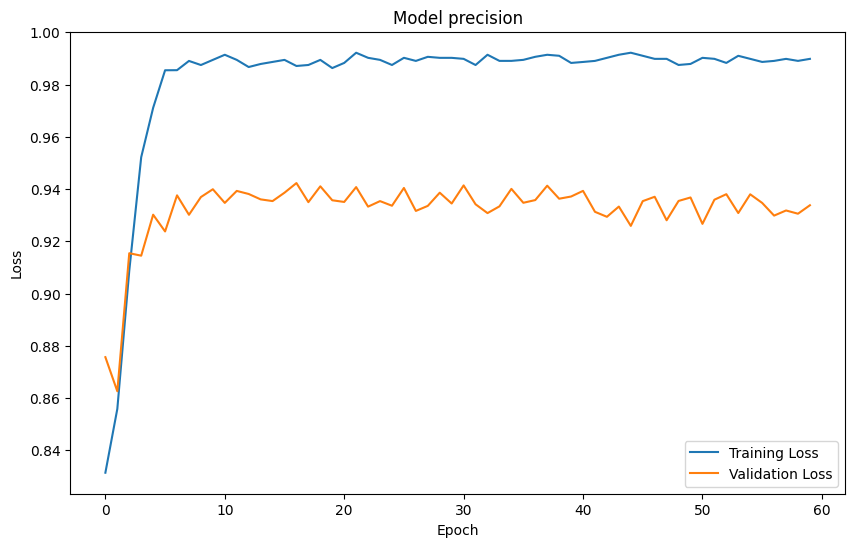

In [31]:
import matplotlib.pyplot as plt

loss_column = 'precision_1'
val_loss_column = 'val_precision_1'

plt.figure(figsize=(10, 6))

plt.plot(combined_df[loss_column], label='Training Loss')

if val_loss_column in combined_df.columns:
    plt.plot(combined_df[val_loss_column], label='Validation Loss')

plt.title('Model precision')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


## AUC

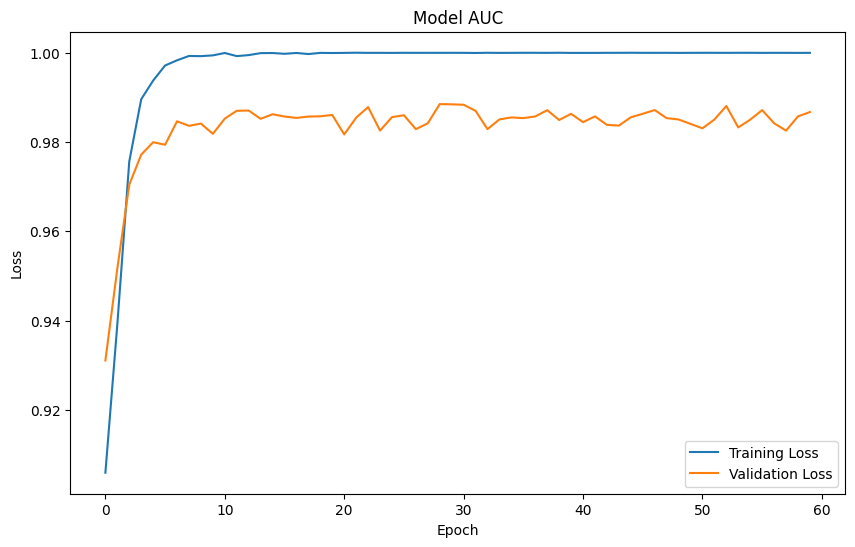

In [32]:
import matplotlib.pyplot as plt

loss_column = 'auc'
val_loss_column = 'val_auc'

plt.figure(figsize=(10, 6))

plt.plot(combined_df[loss_column], label='Training Loss')

if val_loss_column in combined_df.columns:
    plt.plot(combined_df[val_loss_column], label='Validation Loss')

plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Recall

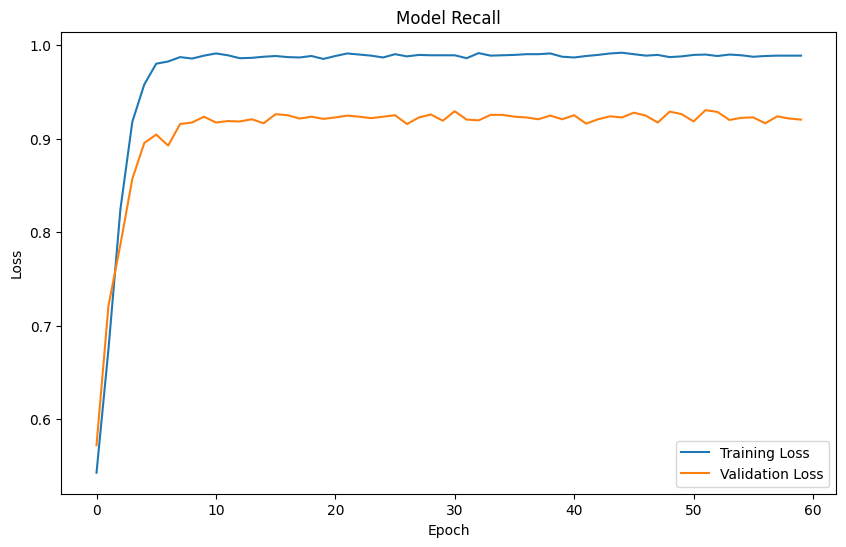

In [34]:
import matplotlib.pyplot as plt

loss_column = 'recall_1'
val_loss_column = 'val_recall_1'

plt.figure(figsize=(10, 6))

plt.plot(combined_df[loss_column], label='Training Loss')

if val_loss_column in combined_df.columns:
    plt.plot(combined_df[val_loss_column], label='Validation Loss')

plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Saving the Metrics

In [35]:
combined_df.to_csv('Metrics.csv', index=False)

In [38]:
!ls

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Preprocessed  model.keras


In [38]:
!zip -r model.zip model.keras

  adding: model.keras (deflated 6%)


In [39]:
from IPython.display import FileLink
FileLink('model.zip')

/kaggle/working/model.zip